In [1]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from torchvision import transforms

#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

In [2]:
IMAGE_SHAPE = (128, 128)

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# datasets
trainset = torchvision.datasets.ImageFolder("../input/dataset/dataset/train", transform = train_transform)
validset = torchvision.datasets.ImageFolder("../input/dataset/dataset/val", transform = test_transform)
testset = torchvision.datasets.ImageFolder("../input/dataset/dataset/test", transform = test_transform)

#batches
batch_size = 16

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

16


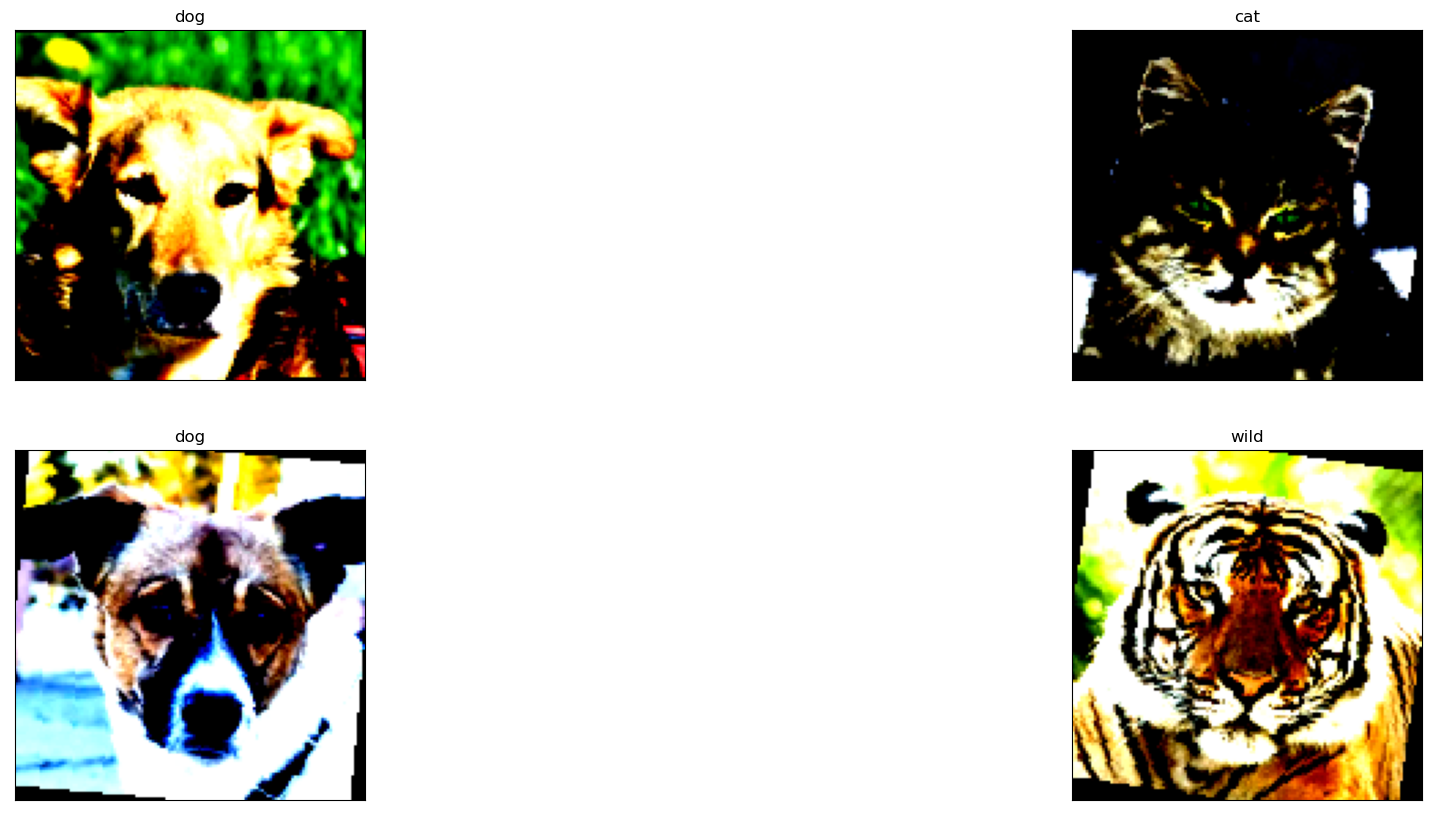

In [3]:
trainItr = iter(trainloader)
images, labels = next(trainItr)
print(len(images))
images, labels = images.numpy() , labels.numpy()


fig = plt.figure(figsize = (25,10))

for i in range(int(batch_size/4)):
    ax = fig.add_subplot(2 , int(batch_size/8) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)))
    ax.set_title(trainset.classes[labels[i]])

In [4]:
print("Unique classes number : ",len(trainset.classes))
print("Classes : ", trainset.classes)

Unique classes number :  3
Classes :  ['cat', 'dog', 'wild']


In [5]:
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device

device(type='cuda')

In [6]:
from torchvision import models

model = models.mobilenet_v2(num_classes=len(trainset.classes),weights=None)
model = model.to(device)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
import csv
import os
from tqdm.auto import tqdm


open("/kaggle/working/training_logs-new.csv", "a", newline="")
log_file = open("/kaggle/working/training_logs-new.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_cost, train_score = loop_fn('train', trainset, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn('val', validset, validloader, model, criterion, optimizer)
    print(epoch, float(train_cost), train_score, float(test_cost), test_score)
    csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])

Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

1 0.00017562836001161486 0.6414012245214291 0.00360665749758482 0.8485412787088765


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

2 0.0006352969794534147 0.848329845772301 0.004623911343514919 0.8603351955307262


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

3 0.00047961497330106795 0.9037433155080213 0.0032661412842571735 0.9162011173184358


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

4 0.0010630962206050754 0.920793613888243 0.0003162090142723173 0.9428926132836747


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

5 9.32379043661058e-05 0.9290862590095327 0.001542205223813653 0.962756052141527


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

6 6.469437266787281e-06 0.941253971944509 0.0008210131200030446 0.9565487274984482


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

7 6.92723406245932e-05 0.946524064171123 0.0005254611605778337 0.9646182495344506


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

8 1.0222296396023012e-06 0.9505541346973572 8.173312380677089e-06 0.9720670391061452


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

9 4.821437869395595e-06 0.9561342323490661 1.341221923212288e-05 0.9621353196772191


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

10 2.557225525379181e-05 0.9566767418429822 0.00022359445574693382 0.9602731222842955


In [11]:
torch.save(model.state_dict(), f"/kaggle/working/_e{epoch}.pth")

In [20]:
PRETRAINED_MODEL = "/kaggle/input/logs-mobilenet-animal-faces/logs/_e10.pth"

In [21]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device
model = models.mobilenet_v2(num_classes=len(testset.classes),pretrained=False)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

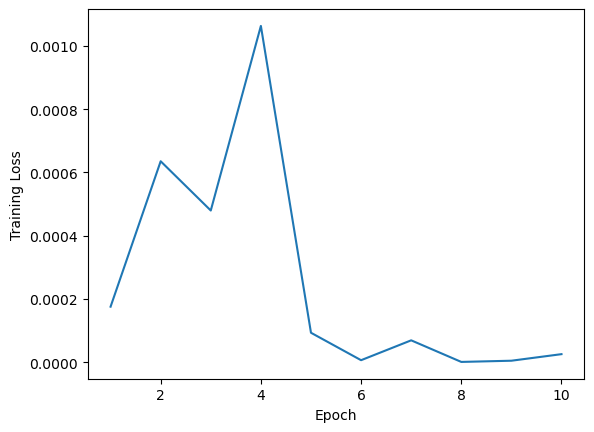

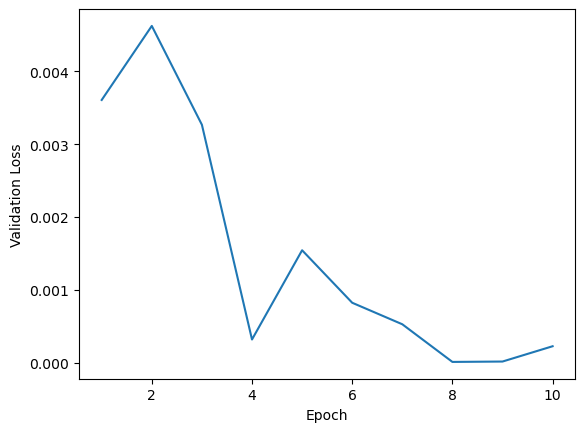

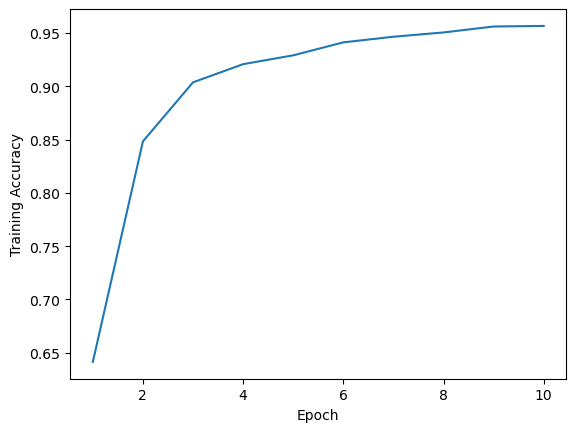

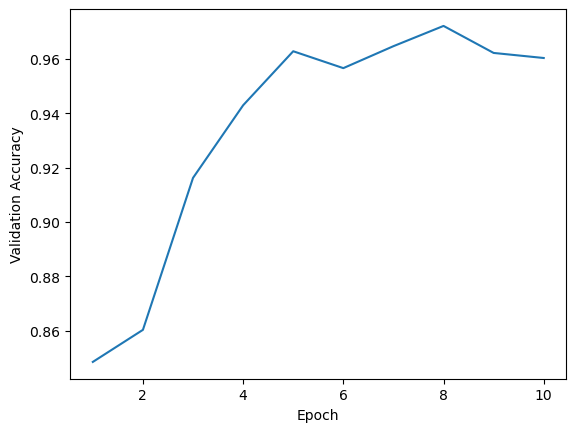

In [22]:
import pandas as pd

df = pd.read_csv("/kaggle/input/logs-mobilenet-animal-faces/logs/training_logs.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(df["epoch"], df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(df["epoch"], df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(df["epoch"], df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(df["epoch"], df["val_acc"])
plt.show()

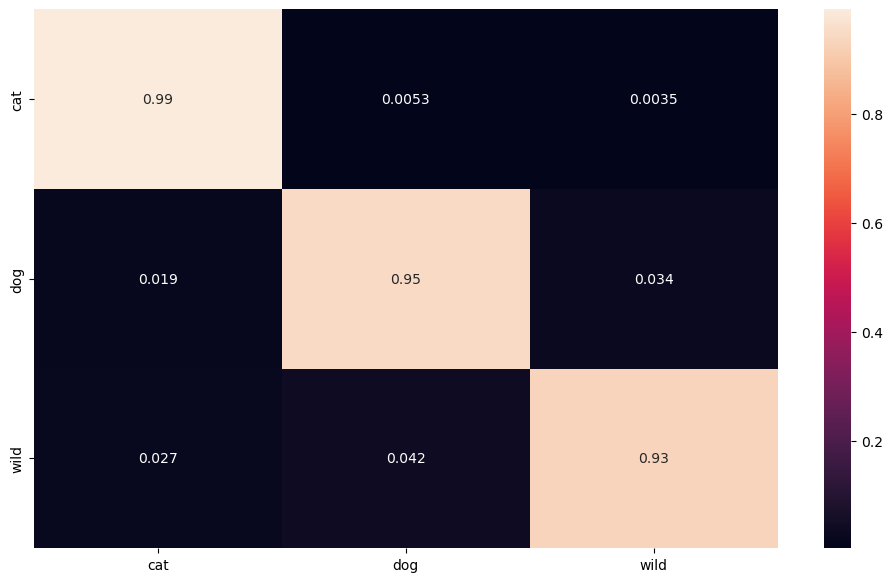

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [24]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=trainset.classes))

Overall Accuracy:  95.73  %
              precision    recall  f1-score   support

         cat       0.96      0.99      0.97       566
         dog       0.95      0.95      0.95       525
        wild       0.96      0.93      0.95       525

    accuracy                           0.96      1616
   macro avg       0.96      0.96      0.96      1616
weighted avg       0.96      0.96      0.96      1616

